# Cytometry Clustering Comparison Project



In [1]:
import pandas as pd
import flowsom as fs
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns
import time

Errore: Indice del job non valido (--f=c:\Users\Simone\AppData\Roaming\jupyter\runtime\kernel-v3be3ea666baf9fbfc78d95aee9a2ef4ffaf013f58.json). Deve essere tra 0 e 24.


SystemExit: 1

c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## 1. Dataset Loading and Initial Analysis


In [ ]:


# Read the two datasets
data_markers = pd.read_csv("datasets\human_blood_mass_cytometry_batch1.csv", index_col=0)      
data_celltypes = pd.read_csv("datasets\human_blood_mass_cytometry_batch1_metadata.csv")  
labels_true = data_celltypes["cell_type"].values
# Print shapes and basic info
print("=== Marker Dataset ===")
print(data_markers.info())
print(data_markers.head())

print("\n=== Cell Type Dataset ===")
print(data_celltypes.info())
print(data_celltypes.head())
        


start = np.random.randint(0, len(data_markers) - 40000 + 1)
X_sample = data_markers.iloc[start:start+40000]
labels_true_sample = labels_true[start:start+40000]

<>:2: SyntaxWarning: invalid escape sequence '\h'
<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:2: SyntaxWarning: invalid escape sequence '\h'
<>:3: SyntaxWarning: invalid escape sequence '\h'
C:\Users\Simone\AppData\Local\Temp\ipykernel_22164\2995365370.py:2: SyntaxWarning: invalid escape sequence '\h'
  data_markers = pd.read_csv("datasets\human_blood_mass_cytometry_batch1.csv", index_col=0)
C:\Users\Simone\AppData\Local\Temp\ipykernel_22164\2995365370.py:3: SyntaxWarning: invalid escape sequence '\h'
  data_celltypes = pd.read_csv("datasets\human_blood_mass_cytometry_batch1_metadata.csv")


=== Marker Dataset ===
<class 'pandas.core.frame.DataFrame'>
Index: 481715 entries, 0 to 481714
Data columns (total 35 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   CD45      481715 non-null  float64
 1   CD66      481715 non-null  float64
 2   CD7       481715 non-null  float64
 3   CD45RA    481715 non-null  float64
 4   CD11b     481715 non-null  float64
 5   CD4       481715 non-null  float64
 6   CD8a      481715 non-null  float64
 7   CD11c     481715 non-null  float64
 8   CD123     481715 non-null  float64
 9   CREB      481715 non-null  float64
 10  STAT5     481715 non-null  float64
 11  p38       481715 non-null  float64
 12  TCRgd     481715 non-null  float64
 13  STAT1     481715 non-null  float64
 14  STAT3     481715 non-null  float64
 15  S6        481715 non-null  float64
 16  CXCR3     481715 non-null  float64
 17  CD161     481715 non-null  float64
 18  CD33      481715 non-null  float64
 19  MAPKAPK2  481715 non-null 

## 2. Dimensionality Reduction


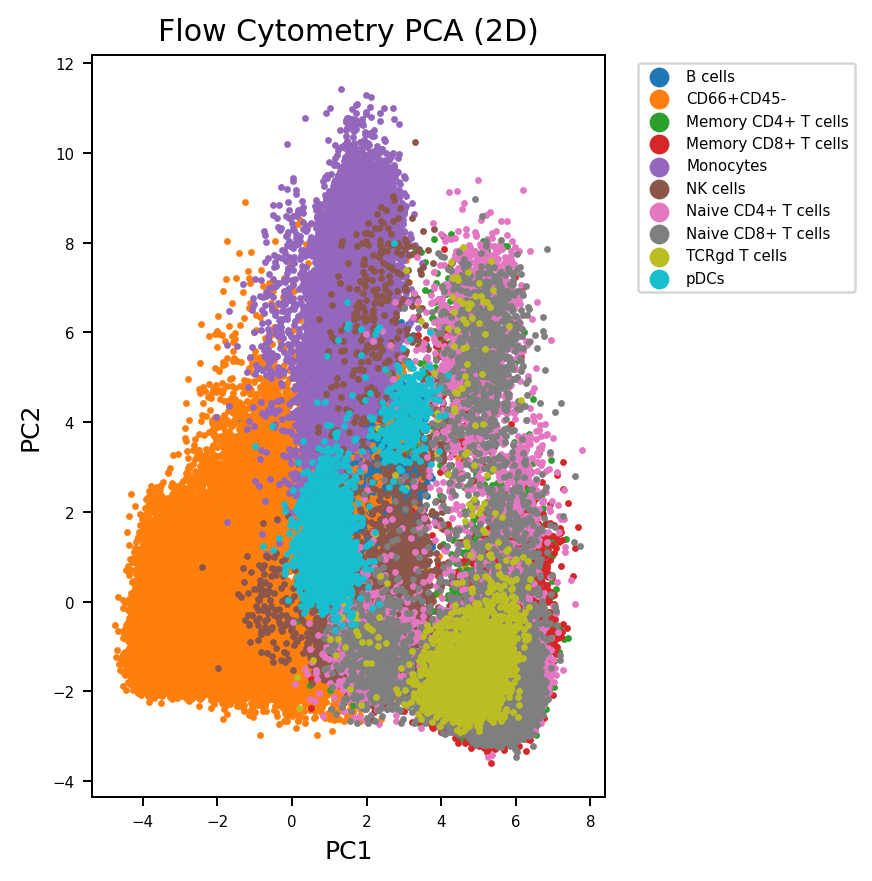

In [4]:
import matplotlib.colors as mcolors

# X = markers
X = data_markers.values
y = labels_true   # <-- contiene stringhe

# PCA 2D
Xp = PCA(n_components=2).fit_transform(X)

# Crea una palette automaticamente con colori distinti
unique_labels = np.unique(y)
colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())

# Crea un dizionario label → colore
palette = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

fig, ax = plt.subplots(dpi=180, figsize=(5, 5))

for label in unique_labels:
    ax.scatter(
        Xp[y == label, 0],
        Xp[y == label, 1],
        s=3,
        label=label,
        c=palette[label]
    )

ax.tick_params(axis='both', which='major', labelsize=6)
ax.legend(bbox_to_anchor=(1.05, 1), markerscale=4., fontsize=6)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Flow Cytometry PCA (2D)')
plt.tight_layout()
plt.show()



## 3. Clustering Methods Implementation


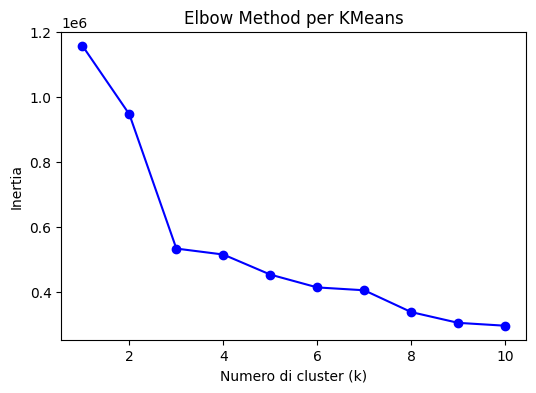

In [ ]:
inertia = []
k_range = range(1, 11)  # Prova con k da 1 a 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_sample)
    inertia.append(kmeans.inertia_)

# Plot dell'elbow
plt.figure(figsize=(6,4))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method per KMeans')
plt.show()



In [6]:

# 2. KMeans con numero di cluster scelto (ad esempio il "gomito")
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_sample)

# Valutazioni
ari = adjusted_rand_score(labels_true_sample, labels)
nmi = normalized_mutual_info_score(labels_true_sample, labels)
silhouette = silhouette_score(X_sample, labels)

print(f"ARI: {ari:.3f} | NMI: {nmi:.3f} | Silhouette: {silhouette:.3f}")


ARI: 0.855 | NMI: 0.718 | Silhouette: 0.473


In [ ]:
sample_sizes = [10000, 20000, 40000, 60000, 80000]
n_runs = 5   
results = []


for size in sample_sizes:
    for run in range(n_runs):

        np.random.seed(100 + run)
        start = np.random.randint(0, len(data_markers) - size + 1)
        X = data_markers.iloc[start:start+size]
        Y = labels_true[start:start+size]
        print(f"Run {run+1}, primo indice selezionato: {start}")

        # 2) Esecuzione FlowSOM
        start = time.time()
        try:
            kmeans = KMeans(n_clusters=3, random_state=42)
            labels = kmeans.fit_predict(X)

            ari = adjusted_rand_score(Y, labels)
            nmi = normalized_mutual_info_score(Y, labels)
            sil = silhouette_score(X, labels)
    
            exec_time = time.time() - start

            results.append({
                "sample_size": size,
                "run": run,
                "ari": ari,
                "nmi": nmi,
                "silhouette": sil,
                "num_clusters": len(np.unique(labels)),
                "time_sec": exec_time
            })

            print(f"[kmeans] size={size} run={run} | "
                  f"ARI={ari:.4f} | NMI={nmi:.4f} | Sil={sil:.4f} | time={exec_time:.2f}s")

        except Exception as e:
            print(f"FAILED: size={size}, run={run}, error={e}")
            results.append({
                "sample_size": size,
                "run": run,
                "ari": np.nan,
                "nmi": np.nan,
                "silhouette": np.nan,
                "num_clusters": np.nan,
                "time_sec": np.nan,
                "error": str(e)
            })

# Salva tutto su CSV
df = pd.DataFrame(results)
df.to_csv("kmeans_results.csv", index=False)


print("\nSaved results to kmeans_stability_results.csv")

Run 1, primo indice selezionato: 300552
[kmeans] size=10000 run=0 | ARI=0.6953 | NMI=0.6879 | Sil=0.3883 | time=6.33s
Run 2, primo indice selezionato: 176991
[kmeans] size=10000 run=1 | ARI=0.8905 | NMI=0.7581 | Sil=0.5512 | time=3.25s
Run 3, primo indice selezionato: 108800
[kmeans] size=10000 run=2 | ARI=0.6805 | NMI=0.6860 | Sil=0.4365 | time=3.08s
Run 4, primo indice selezionato: 448263
[kmeans] size=10000 run=3 | ARI=0.8292 | NMI=0.7168 | Sil=0.4951 | time=2.95s
Run 5, primo indice selezionato: 401477
[kmeans] size=10000 run=4 | ARI=0.8430 | NMI=0.7147 | Sil=0.5083 | time=2.79s
Run 1, primo indice selezionato: 300552
[kmeans] size=20000 run=0 | ARI=0.8212 | NMI=0.6848 | Sil=0.4858 | time=6.99s
Run 2, primo indice selezionato: 176991
[kmeans] size=20000 run=1 | ARI=0.8895 | NMI=0.7564 | Sil=0.5491 | time=5.24s
Run 3, primo indice selezionato: 108800
[kmeans] size=20000 run=2 | ARI=0.8895 | NMI=0.7601 | Sil=0.5417 | time=4.81s
Run 4, primo indice selezionato: 448263
[kmeans] size=20

In [ ]:
# --- Parametri da testare ---
k_values = [2, 3, 4, 5, 6, 8, 10]
linkages = ['ward', 'average', 'complete']
metrics = {
    'ward': ['euclidean'],  
    'average': ['euclidean', 'manhattan', 'cosine'],
    'complete': ['euclidean', 'manhattan', 'cosine']
}

best_result = {
    "score": -1,
    "params": None
}

print("Testing parameters...\n")

for link in linkages:
    for k in k_values:
        for m in metrics[link]:

            if link == "ward" and m != "euclidean":
                continue

            agg = AgglomerativeClustering(
                n_clusters=k,
                linkage=link,
                metric=m if link != "ward" else "euclidean"
            )

            labels = agg.fit_predict(X_sample)

            score = adjusted_rand_score(labels_true_sample, labels)

            print(f"k={k:2d} | link={link:8s} | metric={m:9s} | ARI={score:.4f}")

            if score > best_result["score"]:
                best_result["score"] = score
                best_result["params"] = (k, link, m)

print("\n--- BEST PARAMETERS ---")
print("Silhouette:", best_result["score"])
print("k, linkage, metric:", best_result["params"])


Testing parameters...




--- RUN 1/10 ---
ARI=-0.0063 | NMI=0.0076

--- RUN 2/10 ---
ARI=-0.0050 | NMI=0.0070

--- RUN 3/10 ---
ARI=-0.0062 | NMI=0.0050

--- RUN 4/10 ---
ARI=0.0142 | NMI=0.0048

--- RUN 5/10 ---
ARI=0.0068 | NMI=0.0070

--- RUN 6/10 ---
ARI=-0.0104 | NMI=0.0046

--- RUN 7/10 ---
ARI=-0.0098 | NMI=0.0062

--- RUN 8/10 ---
ARI=0.0142 | NMI=0.0032

--- RUN 9/10 ---
ARI=0.0033 | NMI=0.0061

--- RUN 10/10 ---
ARI=0.0076 | NMI=0.0065


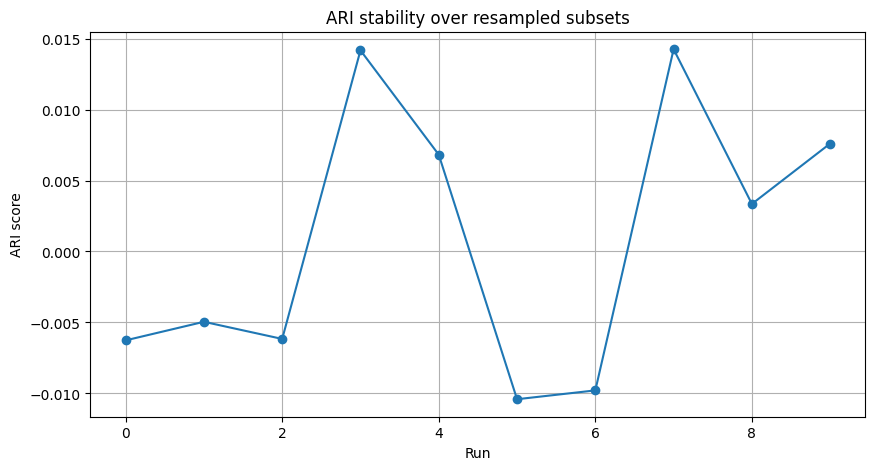

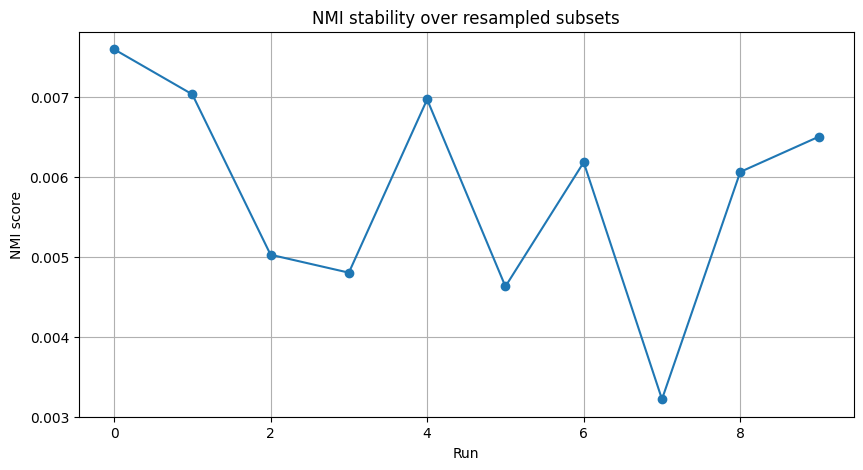


ARI mean: 0.0008623596870365759
NMI mean: 0.005805793564854168


In [ ]:
best_k, best_link, best_metric = best_result["params"]

n_runs = 10

ari_scores = []
nmi_scores = []

for i in range(n_runs):
    print(f"\n--- RUN {i+1}/{n_runs} ---")

    # 3) Clustering con i migliori parametri
    agg = AgglomerativeClustering(
        n_clusters=best_k,
        linkage=best_link,
        metric=best_metric if best_link != "ward" else "euclidean"
    )
    labels = agg.fit_predict(X_sample)

    # 4) Calcolo ARI e NMI
    ari = adjusted_rand_score(labels_true_sample, labels)
    nmi = normalized_mutual_info_score(labels_true_sample, labels)

    ari_scores.append(ari)
    nmi_scores.append(nmi)

    print(f"ARI={ari:.4f} | NMI={nmi:.4f}")

# --------------------------
#  Grafici
# --------------------------

plt.figure(figsize=(10,5))
plt.plot(ari_scores, marker='o')
plt.title("ARI stability over resampled subsets")
plt.xlabel("Run")
plt.ylabel("ARI score")
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(nmi_scores, marker='o')
plt.title("NMI stability over resampled subsets")
plt.xlabel("Run")
plt.ylabel("NMI score")
plt.grid()
plt.show()


In [ ]:

# --- Parametri da testare ---
k_values = [2, 3, 4, 5, 6, 8, 10]
affinities = ['nearest_neighbors', 'rbf']
assign_labels_options = ['kmeans', 'discretize']
n_neighbors_values = [5, 10, 15]  # solo per nearest_neighbors

best = {"score": -1, "params": None}

print("\n--- Starting Spectral Clustering Grid Search ---\n")

for k in k_values:
    for affinity in affinities:
        for assign_labels in assign_labels_options:
            if affinity == 'nearest_neighbors':
                for n_neighbors in n_neighbors_values:
                    try:
                        spectral = SpectralClustering(
                            n_clusters=k,
                            affinity=affinity,
                            assign_labels=assign_labels,
                            n_neighbors=n_neighbors,
                            random_state=42
                        )
                        labels = spectral.fit_predict(X_sample)
                        ari = adjusted_rand_score(labels_true_sample, labels)
                        nmi = normalized_mutual_info_score(labels_true_sample, labels)
                        print(f"k={k}, affinity={affinity}, assign={assign_labels}, n_neighbors={n_neighbors} | ARI={ari:.4f} | NMI={nmi:.4f}")

                        if ari > best["score"]:
                            best["score"] = ari
                            best["params"] = (k, affinity, assign_labels, n_neighbors)
                    except Exception as e:
                        print(f"FAILED: k={k}, affinity={affinity}, assign={assign_labels}, n_neighbors={n_neighbors} | Error={e}")
            else:
                try:
                    spectral = SpectralClustering(
                        n_clusters=k,
                        affinity=affinity,
                        assign_labels=assign_labels,
                        random_state=42
                    )
                    labels = spectral.fit_predict(X_sample)
                    ari = adjusted_rand_score(labels_true_sample, labels)
                    nmi = normalized_mutual_info_score(labels_true_sample, labels)
                    print(f"k={k}, affinity={affinity}, assign={assign_labels} | ARI={ari:.4f} | NMI={nmi:.4f}")

                    if ari > best["score"]:
                        best["score"] = ari
                        best["params"] = (k, affinity, assign_labels, None)
                except Exception as e:
                    print(f"FAILED: k={k}, affinity={affinity}, assign={assign_labels} | Error={e}")

print("\n--- BEST PARAMETERS FOUND ---")
print(best)



--- Starting Spectral Clustering Grid Search ---



In [ ]:

# --- Migliori parametri da grid search ---
best_n_clusters, best_affinity, best_assign_labels, best_n_neighbors = best["params"]

ari_scores = []
nmi_scores = []

for i in range(n_runs):
    print(f"\n--- RUN {i+1}/{n_runs} ---")

    # 2) Clustering con i migliori parametri
    if best_affinity == 'nearest_neighbors':
        spectral = SpectralClustering(
            n_clusters=best_n_clusters,
            affinity=best_affinity,
            assign_labels=best_assign_labels,
            n_neighbors=best_n_neighbors,
            random_state=42
        )
    else:
        spectral = SpectralClustering(
            n_clusters=best_n_clusters,
            affinity=best_affinity,
            assign_labels=best_assign_labels,
            random_state=42
        )

    labels = spectral.fit_predict(X_sample)

    # 3) Calcolo ARI e NMI
    ari = adjusted_rand_score(labels_true_sample, labels)
    nmi = normalized_mutual_info_score(labels_true_sample, labels)

    ari_scores.append(ari)
    nmi_scores.append(nmi)

    print(f"ARI={ari:.4f} | NMI={nmi:.4f}")

# --------------------------
# Grafici
# --------------------------

plt.figure(figsize=(10,5))
plt.plot(ari_scores, marker='o')
plt.title("ARI stability over resampled subsets (Spectral Clustering)")
plt.xlabel("Run")
plt.ylabel("ARI score")
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(nmi_scores, marker='o')
plt.title("NMI stability over resampled subsets (Spectral Clustering)")
plt.xlabel("Run")
plt.ylabel("NMI score")
plt.grid()
plt.show()


In [ ]:
# --- Parametri da testare ---
eps_values = [1.0, 1.5, 2.0, 2.5, 3.0]       # distanza massima
min_samples_values = [5, 10, 15, 20]        # punti minimi per core
metrics = ['euclidean', 'manhattan', 'cosine']

best = {"score": -1, "params": None}

print("\n--- Starting DBSCAN Grid Search ---\n")

for eps in eps_values:
    for min_samples in min_samples_values:
        for metric in metrics:
            try:
                db = DBSCAN(
                    eps=eps,
                    min_samples=min_samples,
                    metric=metric,
                    n_jobs=-1
                )
                labels = db.fit_predict(X_sample)

                # ARI/NMI possono essere negativi se il clustering non trova strutture
                ari = adjusted_rand_score(labels_true_sample, labels)
                nmi = normalized_mutual_info_score(labels_true_sample, labels)

                print(f"eps={eps}, min_samples={min_samples}, metric={metric} | ARI={ari:.4f} | NMI={nmi:.4f}")

                if ari > best["score"]:
                    best["score"] = ari
                    best["params"] = (eps, min_samples, metric)

            except Exception as e:
                print(f"FAILED: eps={eps}, min_samples={min_samples}, metric={metric} | Error={e}")

print("\n--- BEST PARAMETERS FOUND ---")
print(best)



--- Starting DBSCAN Grid Search ---

eps=1.0, min_samples=5, metric=euclidean | ARI=0.0000 | NMI=0.0000
eps=1.0, min_samples=5, metric=manhattan | ARI=0.0000 | NMI=0.0000
FAILED: eps=1.0, min_samples=5, metric=cosine | Error=bad allocation
eps=1.0, min_samples=10, metric=euclidean | ARI=0.0000 | NMI=0.0000
eps=1.0, min_samples=10, metric=manhattan | ARI=0.0000 | NMI=0.0000
FAILED: eps=1.0, min_samples=10, metric=cosine | Error=bad allocation
eps=1.0, min_samples=15, metric=euclidean | ARI=0.0000 | NMI=0.0000
eps=1.0, min_samples=15, metric=manhattan | ARI=0.0000 | NMI=0.0000
FAILED: eps=1.0, min_samples=15, metric=cosine | Error=bad allocation
eps=1.0, min_samples=20, metric=euclidean | ARI=0.0000 | NMI=0.0000
eps=1.0, min_samples=20, metric=manhattan | ARI=0.0000 | NMI=0.0000
FAILED: eps=1.0, min_samples=20, metric=cosine | Error=bad allocation
eps=1.5, min_samples=5, metric=euclidean | ARI=-0.1611 | NMI=0.1331
eps=1.5, min_samples=5, metric=manhattan | ARI=0.0000 | NMI=0.0000
FAILED

In [ ]:
xdims = [2, 3, 4] 
ydims = [2, 3, 4] 
n_clusters_list = [2, 3, 5, 10, 15] 
max_iters = [125, 250, 500] 
learning_rates = [0.0025, 0.005, 0.01]   
best = {"score": -1, "params": None}

for xd in xdims:
    for yd in ydims:
        for nc in n_clusters_list:
            for it in max_iters:
                for lr in learning_rates:

                    try:
                        fsom = fs.FlowSOM(
                            X_sample,
                            cols_to_use=list(range(X_sample.shape[1])), 
                            xdim=xd,
                            ydim=yd,
                            n_clusters=nc,
                            max_iter=it,
                            learning_rate=lr,
                            seed=42
                        )

                        labels = fsom.cluster_labels
                        ari = adjusted_rand_score(labels_true_sample, labels)
                        nmi = normalized_mutual_info_score(labels_true_sample, labels)

                        print(f" → ARI={ari:.4f} | NMI={nmi:.4f}")

                        if ari > best["score"]:
                            best["score"] = ari
                            best["params"] = {
                                "xd": xd,
                                "yd": yd,
                                "nc": nc,
                                "it": it,
                                "lr": lr
    }

                    except Exception as e:
                        print(f"FAILED: xdim={xd}, ydim={yd}, nc={nc}, "
                              f"iter={it}, lr={lr} | Error={e}")

print("\n--- BEST PARAMETERS FOUND ---")
print(f"Best score = {best['score']:.4f}")
print("Best params =", best["params"])


c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\mudata\_core\mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\mudata\_core\mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)
2025-11-28 13:24:35.918 | DEBUG    | flowsom.main:__init__:82 - Reading input.
c:\Users\

 → ARI=0.9185 | NMI=0.8063

--- BEST PARAMETERS FOUND ---
Best score = 0.9185
Best params = {'xd': 2, 'yd': 2, 'nc': 2, 'it': 125, 'lr': 0.0025}


In [ ]:
sample_sizes = [10000, 20000, 40000, 60000, 80000]
n_runs = 5   
results = []


for size in sample_sizes:
    for run in range(n_runs):

        np.random.seed(100 + run)
        start = np.random.randint(0, len(data_markers) - size + 1)
        X = data_markers.iloc[start:start+size]
        Y = labels_true[start:start+size]
        print(f"Run {run+1}, primo indice selezionato: {start}")

        # 2) Esecuzione FlowSOM
        start = time.time()
        try:
            best_params = best["params"]   # alias più comodo

            fsom = fs.FlowSOM(
                X,
                cols_to_use=list(range(X.shape[1])),
                xdim=best_params["xd"],
                ydim=best_params["yd"],
                n_clusters=best_params["nc"],
                max_iter=best_params["it"],
                learning_rate=best_params["lr"],
                seed=42
            )

            labels = fsom.cluster_labels

            ari = adjusted_rand_score(Y, labels)
            nmi = normalized_mutual_info_score(Y, labels)
            sil = silhouette_score(X, labels)
    

            exec_time = time.time() - start

            results.append({
                "sample_size": size,
                "run": run,
                "ari": ari,
                "nmi": nmi,
                "silhouette": sil,
                "num_clusters": len(np.unique(labels)),
                "time_sec": exec_time
            })

            print(f"[FlowSOM] size={size} run={run} | "
                  f"ARI={ari:.4f} | NMI={nmi:.4f} | Sil={sil:.4f} | time={exec_time:.2f}s")

        except Exception as e:
            print(f"FAILED: size={size}, run={run}, error={e}")
            results.append({
                "sample_size": size,
                "run": run,
                "ari": np.nan,
                "nmi": np.nan,
                "silhouette": np.nan,
                "num_clusters": np.nan,
                "time_sec": np.nan,
                "error": str(e)
            })

# Salva tutto su CSV
df = pd.DataFrame(results)
df.to_csv("flowsom_results.csv", index=False)

print("\nSaved results to flowsom_stability_results.csv")


c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\mudata\_core\mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\mudata\_core\mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)
2025-11-28 13:24:49.052 | DEBUG    | flowsom.main:__init__:82 - Reading input.


c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
2025-11-28 13:24:49.067 | DEBUG    | flowsom.main:__init__:84 - Fitting model: clustering and metaclustering.


Run 1, primo indice selezionato: 300552


2025-11-28 13:24:49.237 | DEBUG    | flowsom.main:__init__:86 - Updating derived values.
c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\flowsom\main.py:93: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  if "clustering" in self.mudata["cell_data"].obs_keys():
c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\mudata\_core\mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\mudata\_core\mudata.py:1461: FutureWarning: From 0

[FlowSOM] size=10000 run=0 | ARI=0.8847 | NMI=0.7731 | Sil=0.4793 | time=4.15s
Run 2, primo indice selezionato: 176991


2025-11-28 13:24:53.447 | DEBUG    | flowsom.main:__init__:86 - Updating derived values.
c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\flowsom\main.py:93: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  if "clustering" in self.mudata["cell_data"].obs_keys():
c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\mudata\_core\mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\mudata\_core\mudata.py:1461: FutureWarning: From 0

[FlowSOM] size=10000 run=1 | ARI=0.9435 | NMI=0.8357 | Sil=0.5392 | time=4.49s
Run 3, primo indice selezionato: 108800


c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\flowsom\main.py:93: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  if "clustering" in self.mudata["cell_data"].obs_keys():
c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\mudata\_core\mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\mudata\_core\mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore.

[FlowSOM] size=10000 run=2 | ARI=0.9425 | NMI=0.8391 | Sil=0.5129 | time=3.88s
Run 4, primo indice selezionato: 448263


c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\flowsom\main.py:93: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  if "clustering" in self.mudata["cell_data"].obs_keys():
c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\mudata\_core\mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\mudata\_core\mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore.

[FlowSOM] size=10000 run=3 | ARI=0.4461 | NMI=0.6223 | Sil=0.2545 | time=3.34s
Run 5, primo indice selezionato: 401477


c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\flowsom\main.py:93: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  if "clustering" in self.mudata["cell_data"].obs_keys():


[FlowSOM] size=10000 run=4 | ARI=0.8440 | NMI=0.7196 | Sil=0.5079 | time=3.63s

Saved results to flowsom_stability_results.csv


In [11]:
import phenograph

# --- Range di valori da testare ---
#k_values = [20, 30, 40, 50, 60]
k_values = [50, 52, 55]
best = {"score": -1, "params": None}

print("\n--- Starting PhenoGraph Grid Search ---\n")

for k in k_values:
    try:
        print(f"Testing: k={k}")

        communities, graph, Q = phenograph.cluster(X_sample, k=k)
        labels = np.array(communities)

        ari = adjusted_rand_score(labels_true_sample, labels)
        nmi = normalized_mutual_info_score(labels_true_sample, labels)

        print(f"k={k} | ARI={ari:.4f} | NMI={nmi:.4f}")

        if ari > best["score"]:
            best["score"] = ari
            best["params"] = k

    except Exception as e:
        print(f"FAILED: k={k} | Error={e}")

print("\n--- BEST PARAMETERS FOUND ---")
print(best)


--- Starting PhenoGraph Grid Search ---

Testing: k=50
Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 8.384103775024414 seconds
Jaccard graph constructed in 35.883711099624634 seconds
Wrote graph to binary file in 4.52178692817688 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.904979
Louvain completed 21 runs in 148.5763852596283 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 206.05016326904297 seconds
k=50 | ARI=0.2765 | NMI=0.6383
Testing: k=52
Finding 52 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 10.325385808944702 seconds
Jaccard graph constructed in 31.445805311203003 seconds
Wrote graph to binary file in 3.499551296234131 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.904477
Louvain completed 21 runs in 147.4340319633484 seconds
Sorting communities by size, please wait ...
Phen

In [ ]:
from flowsom import FlowGrid

min_cell_sizes = [5, 10, 20]
min_samples_list = [3, 5]
grid_sizes = [20, 30]
density_thresholds = [0.2, 0.4]

best = {"score": -1, "params": None}

print("\n--- Starting FlowGrid Grid Search ---\n")

for min_cell_size in min_cell_sizes:
    for min_samples in min_samples_list:
        for grid_size in grid_sizes:
            for density_threshold in density_thresholds:

                params = {
                    "min_cell_size": min_cell_size,
                    "min_samples": min_samples,
                    "grid_size": grid_size,
                    "density_threshold": density_threshold
                }

                try:
                    print(f"Testing: {params}")

                    fg = FlowGrid(
                        min_cell_size=min_cell_size,
                        min_samples=min_samples,
                        grid_size=grid_size,
                        density_threshold=density_threshold
                    )

                    labels = fg.fit_predict(X_sample)

                    # Se FlowGrid restituisce 0 cluster (può capitare)
                    if len(np.unique(labels)) <= 1:
                        ari = -1
                        nmi = -1
                    else:
                        ari = adjusted_rand_score(labels_true_sample, labels)
                        nmi = normalized_mutual_info_score(labels_true_sample, labels)

                    print(f"ARI={ari:.4f} | NMI={nmi:.4f}")

                    # Aggiorna best
                    if ari > best["score"]:
                        best["score"] = ari
                        best["params"] = params

                except Exception as e:
                    print(f"FAILED: {params} | Error={e}")

print("\n--- BEST PARAMETERS FOUND ---")
print(best)


Errore: Indice del job non valido (--f=c:\Users\Simone\AppData\Roaming\jupyter\runtime\kernel-v3be3ea666baf9fbfc78d95aee9a2ef4ffaf013f58.json). Deve essere tra 0 e 24.


SystemExit: 1

## 4. Evaluation clustering methods


In [ ]:
labels_random = np.random.permutation(labels_true)
print("ARI random:", adjusted_rand_score(labels_true, labels_random))


ARI random: -0.0017099783977315693
